In [ ]:
pip install -r requirements.txt

In [2]:
# Begin by importing the basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings

#I have a few warnings I don't want to clutter the markdown file with
warnings.simplefilter(action='ignore', category=FutureWarning)

#Next read in the dataset
demand_df = pd.read_csv("../assets/dataset/base-historical-product-demand.csv")

#View the first 3 rows of the data, to see what it looks like
demand_df.head(3)

# determine the statistical details of the numerical values
print(demand_df.describe())

#What is the missing values in each of the columns
print(demand_df.isnull().sum())

#Remove null values from the date column
demand_df = demand_df[demand_df['Date'].notnull()]

# Find the minimum and maximum dates
min_date = demand_df['Date'].min()
max_date = demand_df['Date'].max()

print(f"The earliest date is: {min_date}")
print(f"The latest date is: {max_date}")

       Order_Demand
count  1.048575e+06
mean   4.867427e+03
std    2.893346e+04
min   -9.990000e+05
25%    1.800000e+01
50%    3.000000e+02
75%    2.000000e+03
max    4.000000e+06
Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
The earliest date is: 1/1/2012
The latest date is: 9/9/2016


int64


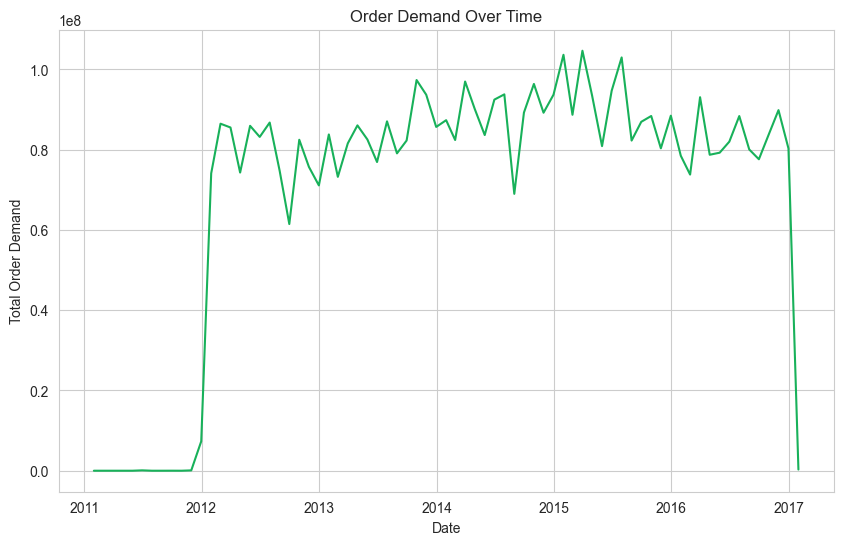

   Product_Code Warehouse Product_Category       Date  Order_Demand
0  Product_0993    Whse_J     Category_028 2012-07-27           100
1  Product_0979    Whse_J     Category_028 2012-01-19           500
2  Product_0979    Whse_J     Category_028 2012-02-03           500
3  Product_0979    Whse_J     Category_028 2012-02-09           500
4  Product_0979    Whse_J     Category_028 2012-03-02           500


In [3]:
#Before we can begin visualizing, a few changes need to occur, like data types and groupings
#This will allow our visuals to populate quicker

#Make sure Order_demand is read in as a numeric datatype
print(demand_df['Order_Demand'].dtypes)

#Need to change the date to a date datatype from an object
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df['Order_Demand'] = pd.to_numeric(demand_df['Order_Demand'], errors='coerce')

#Finally Grouping
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df_group = demand_df.groupby(pd.Grouper(key='Date', freq='M'))['Order_Demand'].sum().reset_index()

#Plot the new dataset
sns.set_style("whitegrid") #Set tje style
plt.figure(figsize=(10, 6))
sns.lineplot(data=demand_df_group, x='Date', y='Order_Demand', color = '#18B15A')
plt.title('Order Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Total Order Demand')
plt.show()

#Now that we see the overall plot, we notice that any dates prior to 2012 are going
#to be irrelevant. We can remove these values
print(demand_df.head())

#Now that we see the overall plot, we notice that any dates prior to 2012 are going
#to be irrelevant. We can remove these values
demand_df = demand_df[demand_df['Date']>'2011-12-31']

#Lets see what this looks like grouped by warehouse, to understand which of our warehouses receive the most demand
demand_df_group_warehouse = demand_df.groupby(['Date', 'Warehouse'])['Order_Demand'].sum().reset_index()

#Plot this faceted now
#Found out I need to use sns.relplot, as lineplot does not read facets well
g = sns.relplot(data=demand_df_group_warehouse, 
                x='Date', 
                y='Order_Demand', 
                kind="line",
                hue='Warehouse',
                palette=["#EF9A9A", "#673AB7", "#039BE5", "#FB8C00"],
                col='Warehouse',  # Facet by 'Warehouse'
                col_wrap=2,  
                height=3, aspect=1.5)
plt.show()





In [ ]:
#We will begin by breaking each warehouse into its own dataframe
whse_s_df = demand_df[demand_df['Warehouse']=='Whse_S']
whse_a_df = demand_df[demand_df['Warehouse']=='Whse_A']
whse_c_df = demand_df[demand_df['Warehouse']=='Whse_C']
whse_j_df = demand_df[demand_df['Warehouse']=='Whse_J']

#Now we can begin looking at the product category of the demand
whse_s_df_group_category = whse_s_df.groupby(['Date', 'Product_Category'])['Order_Demand'].sum().reset_index().sort_values('Order_Demand', ascending=False)
plt.figure(figsize=(7, 5))
sns.barplot(data=whse_s_df_group_category, x='Product_Category', y='Order_Demand', color ="#EF9A9A")
plt.title('Warehouse S Product Demand')
plt.xlabel('Product Category')
plt.xticks(rotation=90)
plt.ylabel('Product Demand')
plt.show()

#Rinse and repeat for all of the other datatypes
whse_a_df_group_category = whse_a_df.groupby(['Date', 'Product_Category'])['Order_Demand'].sum().reset_index().sort_values('Order_Demand', ascending=False)
plt.figure(figsize=(7, 5))
sns.barplot(data=whse_a_df_group_category, x='Product_Category', y='Order_Demand', color ="#673AB7")
plt.title('Warehouse A Product Demand')
plt.xlabel('Product Category')
plt.xticks(rotation=90)
plt.ylabel('Product Demand')
plt.show()

whse_c_df_group_category = whse_c_df.groupby(['Date', 'Product_Category'])['Order_Demand'].sum().reset_index().sort_values('Order_Demand', ascending=False)
plt.figure(figsize=(7, 5))
sns.barplot(data=whse_c_df_group_category, x='Product_Category', y='Order_Demand', color ="#039BE5")
plt.title('Warehouse C Product Demand')
plt.xlabel('Product Category')
plt.xticks(rotation=90)
plt.ylabel('Product Demand')
plt.show()

whse_j_df_group_category = whse_j_df.groupby(['Date', 'Product_Category'])['Order_Demand'].sum().reset_index().sort_values('Order_Demand', ascending=False)
plt.figure(figsize=(7, 5))
sns.barplot(data=whse_j_df_group_category, x='Product_Category', y='Order_Demand', color ="#FB8C00")
plt.title('Warehouse J Product Demand')
plt.xlabel('Product Category')
plt.xticks(rotation=90)
plt.ylabel('Product Demand')
plt.show()

#Now before building out the demand forecast, lets go ahead and isolate product 19 at the largest warehouse
whse_j_df_cat_19 = whse_j_df[whse_j_df['Product_Category']=='Category_019']
whse_j_df_cat_19_group = whse_j_df_cat_19.groupby(pd.Grouper(key='Date', freq='M'))['Order_Demand'].sum().reset_index()

sns.set_style("whitegrid") #Set tje style
plt.figure(figsize=(10, 6))
sns.lineplot(data=whse_j_df_cat_19_group, x='Date', y='Order_Demand', color = '#FB8C00')
plt.title('Warehouse J Category 19 Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Total Order Demand')
plt.show()




In [ ]:
#Build the data we will work with from the original data structure to give us more points
category_19_df = demand_df[(demand_df['Warehouse'] == 'Whse_J') & (demand_df['Product_Category'] == 'Category_019')]

#Select only two columns
category_19_df = category_19_df.loc[:, ['Date', 'Order_Demand']]
category_19_df['Date'] = pd.to_datetime(category_19_df['Date'])
category_19_df['Order_Demand'] = pd.to_numeric(category_19_df['Order_Demand'], errors='coerce')

# Lets remember our data structure, before we begin manipulating to predict future values:
#print (category_19_df.head(5))

#Using SciKit Learn elements, we will build and test the model

# Approximating months by dividing days by average number of days per month
category_19_df['Time'] = (category_19_df['Date'] - category_19_df['Date'].min()) / np.timedelta64(1, 'D')
category_19_df['Time'] = category_19_df['Time'].astype(int)
print (category_19_df.head(15))

#Replace NaN values
category_19_df = category_19_df.dropna(subset=['Order_Demand'])

# Split data into training and testing sets
X = category_19_df[['Time']]
y = category_19_df['Order_Demand']

print(X.head(5))
print(y.head(5))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict using the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)

# Forecast future values
future_times = np.array([X['Time'].max() + i for i in range(1, 31)]).reshape(-1, 1)
future_predictions = model.predict(future_times)
future_predictions = np.round(future_predictions, 2)
print("Future Predictions: ", future_predictions)

# lets see how the data compares to the rest of the data:
print (f"mean is: {category_19_df['Order_Demand'].mean()}")
print (f"median is: {category_19_df['Order_Demand'].median()}")
print (f"mode is: {category_19_df['Order_Demand'].mode()}")
